In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, Activation, RepeatVector, TimeDistributed
from keras.regularizers import l1
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import math

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

plt.switch_backend('TkAgg')
%matplotlib inline

# get data
fname = "./datos.csv"
data = pd.read_csv(fname, index_col=0)
data.index = data.index.astype("datetime64[ns]")
data.sort_index(ascending=True, inplace=True)
data_fixed = data.groupby(lambda x: x.weekofyear).transform(lambda x: x.fillna(x.mean()))
all_levels = data_fixed.iloc[:, :6].values.astype("float64")
names = data_fixed.columns[:6]
river_i_list = [0,1,2,3,4,5]
river_i_list = [5]

np.random.seed(7)

# Get current size
fig_size = plt.rcParams["figure.figsize"]
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

Using TensorFlow backend.


In [12]:
def train_test_split(dataset, train_frac):
    train_size = int(len(dataset)*train_frac)
    return dataset[:train_size, :], dataset[train_size: ,:]

def create_datasets(dataset, look_back=1, look_ahead=1):
    data_x, data_y = [], []
    for i in range(len(dataset)-look_back-look_ahead+1):
        window = dataset[i:(i+look_back), 0]
        data_x.append(window)
        data_y.append(dataset[i + look_back:i + look_back + look_ahead , 0])
    return np.array(data_x), np.array(data_y)

def reverse_scale(data, mean, std):
    for x in np.nditer(data, op_flags=['readwrite']):
        x[...] = x*std + mean
    return data

def calculate_error(train_y, test_y, pred_train, pred_test):
    test_score = math.sqrt(mean_squared_error(test_y, pred_test))
    train_score = math.sqrt(mean_squared_error(train_y, pred_train))
    return train_score, test_score

def mean_absolute_percentage(y, y_pred):
    return np.mean(np.abs((y - y_pred) / y)) * 100

def root_mse(pred_test, test_y):
    t = []
    for i in range(20):
        score = math.sqrt(mean_squared_error(pred_test[:,i,:], test_y[:,i,:]))
        t.append(score)
        print(i+1, "  ->  ", score)
        
    return score

def plot_4_errors(pred_test, test_y, er1, er2, er3 ):
    plt.subplot(221)
    plt.plot(test_y[:,23,:], label="Observed")
    plt.plot(pred_test[:,23,:], color="red", label="Predicted, MAPE: "+ str(round(er1, 5))+"%")
    plt.title("24 step ahead prediction")
    plt.ylabel("River Level")
    plt.legend(loc=1, fontsize = 8, framealpha=0.8)
    
    plt.subplot(222)
    plt.plot(pred_test[:,47,:], color="red", label="Predicted, MAPE: "+ str(round(er2, 5))+"%")
    plt.plot(test_y[:,47,:], label="Observed")
    plt.title("48 step ahead prediction")
    plt.legend(loc=1, fontsize = 8, framealpha=0.8)

    plt.subplot(223)
    plt.plot(pred_test[:,71,:], color="red", label="Predicted, MAPE: "+ str(round(er3, 5))+"%")
    plt.plot(test_y[:,71,:], label="Observed")
    plt.title("72 step ahead prediction")
    plt.legend(loc=1, fontsize = 8, framealpha=0.8)
    plt.tight_layout()
    plt.show()



In [8]:
def do_everything(look_back, look_ahead, river_level, split, epochs, batch_size, model):
    river = river_level
    # river = all_levels[all_levels['riverstation_id'] == riverstation_id]['level'].values
    
    river_mean, river_std = river.mean(), river.std()

    river = preprocessing.scale(river).reshape(len(river), 1)

    # split data into train and test subsets
    train, test = train_test_split(river, split)
    train_x, train_y = create_datasets(train, look_back, look_ahead)
    test_x, test_y = create_datasets(test, look_back, look_ahead)

    # reshape the data to match Keras LSTM gate input [samples, time steps, features]
    train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
    train_y = np.reshape(train_y, (train_y.shape[0], train_y.shape[1], 1))

    test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))
    test_y = np.reshape(test_y, (test_y.shape[0], test_y.shape[1], 1))


    model.fit(train_x, 
              train_y, 
              epochs=epochs, 
              batch_size=batch_size, 
              verbose=3,
              validation_split = 0.1,
              callbacks = [
                EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, verbose=2, mode='auto')
              ]
             )

    pred_train = model.predict(train_x)
    pred_test = model.predict(test_x)

    pred_train = reverse_scale(pred_train, river_mean, river_std)
    pred_test = reverse_scale(pred_test, river_mean, river_std)
    test_y = reverse_scale(test_y, river_mean, river_std)
    train_y = reverse_scale(train_y, river_mean, river_std)
    
    errors = []
    for i in range(test_y.shape[1]):
        errors.append(mean_absolute_percentage(test_y[:,i,:], pred_test[:,i,:]))
        
    plot_4_errors(pred_test, test_y, errors[23], errors[47], errors[71])
    # root_mse(pred_test, test_y)
    
    return errors, model

In [21]:
scores = []
model_list = []
river_i_list = [5]
look_back = 24*5
look_ahead = 72+1
split = 0.8
epochs = 20
batch_size = 280
model = build_seq2seq_model(look_ahead)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, 16)                864       
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 73, 16)            0         
_________________________________________________________________
gru_11 (GRU)                 (None, 73, 8)             600       
_________________________________________________________________
gru_12 (GRU)                 (None, 73, 8)             408       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 73, 1)             9         
Total params: 1,881
Trainable params: 1,881
Non-trainable params: 0
_________________________________________________________________


Train on 68842 samples, validate on 7650 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 00006: early stopping


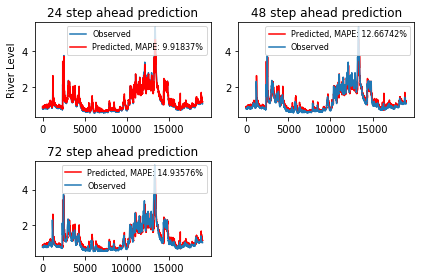

In [22]:
for i in river_i_list:
    river_level=all_levels[:, i]
    err = do_everything(look_back, look_ahead, river_level, split, epochs, batch_size, model)
    scores.append(err)
    model_list.append(model)

In [23]:
scores

[([6.445294232941894,
   3.4696206503218336,
   4.7242274646766695,
   6.200400877964122,
   7.107122397963929,
   7.58988000906122,
   7.879332746309349,
   8.090351669349436,
   8.266839072351248,
   8.420022648515499,
   8.557850987984622,
   8.680340876623356,
   8.790630804171466,
   8.893114045122807,
   8.992541906483293,
   9.094002267545537,
   9.194896694935647,
   9.296269869895616,
   9.397329505342695,
   9.499042858839665,
   9.602093542569435,
   9.706279060935874,
   9.812188425055004,
   9.918374663544798,
   10.024884670663575,
   10.134220900116402,
   10.245627525514294,
   10.361951447313844,
   10.48178973084197,
   10.60295553314722,
   10.723744151471589,
   10.844539386732091,
   10.965604769070994,
   11.085108893720344,
   11.203920142740555,
   11.322411593840911,
   11.440973333194393,
   11.55750714772303,
   11.671657910358277,
   11.784985155115795,
   11.89805419210041,
   12.010676614455436,
   12.12314215437585,
   12.235922214136245,
   12.3457859972

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 16)                864       
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 72, 16)            0         
_________________________________________________________________
gru_8 (GRU)                  (None, 72, 8)             600       
_________________________________________________________________
gru_9 (GRU)                  (None, 72, 8)             408       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 72, 1)             9         
Total params: 1,881
Trainable params: 1,881
Non-trainable params: 0
_________________________________________________________________


In [15]:
import pickle

In [20]:
with open("rnn_globals.pkl", "wb") as f:
    pickle.dump("model", f)

In [ ]:
model.predict()